<span style = "font-family: Arial; font-weight:bold;font-size:2.5em;color:blue;">Health Analytics Mini Case Study (SQL)

Health Analytics Using SQL

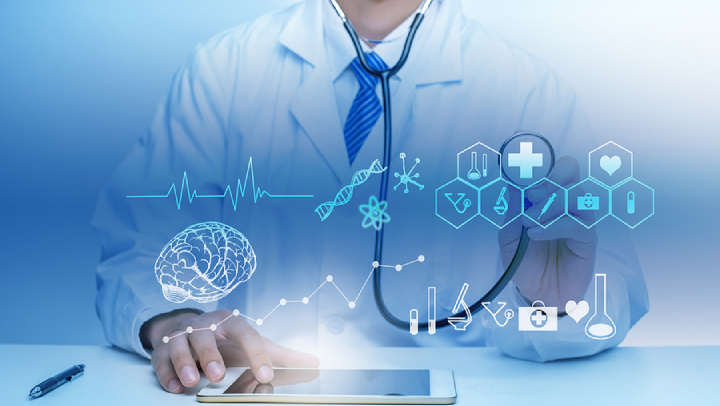



*Source*: [Benefits Of Using Data Analytics In Healthcare](https://www.bridgingminds.net/top-4-benefits-of-using-data-analytics-in-healthcare/)

<span style = "font-family: Arial; font-weight:bold;font-size:2.2em;color:black;"> Introduction

The General Manager of Analytics at Health Co has urgently requested help analyzing their `health.user_logs` dataset. 

We have been asked to quickly analyse the dataset and answer questions about active users for an upcoming board meeting.

---

<span style = "font-family: Arial; font-weight:bold;font-size:2.2em;color:black;"> Business Questions

Let’s cover the business questions that we need to help the GM answer!

1. How many unique users exist in the logs dataset?
2. How many total measurements do we have per user on average?
3. What about the median number of measurements per user?
4. How many users have 3 or more measurements?
5. How many users have 1,000 or more measurements?

Looking at the logs data - what is the number and percentage of the active user base who:

6. Have logged blood glucose measurements?
7. Have at least 2 types of measurements?
8. Have all 3 measures - blood glucose, weight and blood pressure?

For users that have blood pressure measurements:

9. What is the median systolic/diastolic blood pressure values?

---

<span style = "font-family: Arial; font-weight:bold;font-size:2.2em;color:black;"> Dataset Info

The provided `health.user_logs` dataset contains the following variables:

1. id
2. log_date
3. measure
4. measure_value
5. systolic
6. diastolic

---

# Importing Libraries

In [1]:
import pyodbc
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

---

# Database connection

In [2]:
# Define your MSSQL server connection parameters
Server   = "SeanSD\SQLEXPRESS"
Database = "health"
UID      = ""
PWD      = ""

connection_str = ("Driver={SQL Server Native Client 11.0};"
                  "Server=" + Server + ";"
                  "Database=" + Database + ";"
                  "Trusted_Connection=yes;")

try:
    connection = pyodbc.connect(connection_str)
    print ("Connected to SQL database Server:", Server, "\nDatabase: " + Database)
except pyodbc.Error as ex:
    sqlstate = ex.args[1]
    print ("Unable to connect: ", sqlstate)

Connected to SQL database Server: SeanSD\SQLEXPRESS 
Database: health


---

# Exploring database

**Lets view the first 5 rows**

In [3]:
query_str = """SELECT TOP(5)* FROM user_logs;"""

pd.read_sql(query_str, connection)

,id,log_date,measure,measure_value,systolic,diastolic
0,fa28f948a740320ad56b81a24744c8b81df119fa,2020-11-15,weight,46.03959,NaN,NaN
1,1a7366eef15512d8f38133e7ce9778bce5b4a21e,2020-10-10,blood_glucose,97.00000,0.0,0.0
2,bd7eece38fb4ec71b3282d60080d296c4cf6ad5e,2020-10-18,blood_glucose,120.00000,0.0,0.0
3,0f7b13f3f0512e6546b8d2c0d56e564a2408536a,2020-10-17,blood_glucose,232.00000,0.0,0.0
4,d14df0c8c1a5f172476b2a1b1f53cf23c6992027,2020-10-15,blood_pressure,140.00000,140.0,113.0


---

**Unique measures**

In [4]:
query_str = """SELECT DISTINCT measure FROM user_logs;"""

pd.read_sql(query_str, connection)

,measure
0,weight
1,blood_pressure
2,blood_glucose


---

**Using Python to get structure and missing value summary**

In [5]:
# Table you want to examine
table_name = 'user_logs'

# Get column information for the specific table
cursor = connection.cursor()
columns_query = f"""
SELECT COLUMN_NAME, DATA_TYPE
FROM information_schema.columns
WHERE table_name = '{table_name}'
"""
cursor.execute(columns_query)
columns = cursor.fetchall()

# Get row count for the specific table
row_count_query = f"""
SELECT COUNT(*) FROM {table_name}
"""
cursor.execute(row_count_query)
row_count = cursor.fetchone()[0]

print(f"Table: \033[1m{table_name}\033[0m\n")
print(f"Columns: \033[1m{len(columns)}\033[0m")
print(f"Rows: \033[1m{row_count}\033[0m\n")

# Display column information
for column in columns:
    column_name, data_type = column
    print(f"\tColumn: \033[1m{column_name}\033[0m ({data_type})")

# Initialize a dictionary to store the count of missing values for each column
missing_value_counts = {}

# Loop through the columns and calculate the count of missing values
for column in columns:
    column_name = column.COLUMN_NAME
    missing_value_query = f"""
    SELECT COUNT(*) FROM {table_name}
    WHERE {column_name} IS NULL
    """
    cursor.execute(missing_value_query)
    missing_value_count = cursor.fetchone()[0]
    if missing_value_count > 0:
        missing_value_counts[column_name] = missing_value_count

# Display the columns with missing values
print(f"\nColumns with Missing Values in {table_name}:")
for column_name, missing_count in missing_value_counts.items():
    print(f"\t\033[1m{column_name}\033[0m {missing_count}")
    
# Close the cursor
cursor.close()


Table: user_logs

Columns: 6
Rows: 43891

	Column: id (nvarchar)
	Column: log_date (datetime)
	Column: measure (nvarchar)
	Column: measure_value (float)
	Column: systolic (float)
	Column: diastolic (float)

Columns with Missing Values in user_logs:
	systolic 26023
	diastolic 26023


---

# Business Questions

## How many unique users exist in the logs dataset?

In [6]:
query_str = """SELECT
  COUNT (DISTINCT id) AS unique_users
FROM user_logs"""

pd.read_sql(query_str, connection)

,unique_users
0,554


---

**Lets create a table for questions 2-8**

In [7]:
try:
    # Create a cursor for the connection
    cursor = connection.cursor()

    # Drop the table if it exists
    drop_table_sql = """
    IF OBJECT_ID('user_measure_count', 'U') IS NOT NULL
        DROP TABLE user_measure_count;
    """
    # Execute the SQL code to drop the table if it exists
    cursor.execute(drop_table_sql)

    # Create a table with the required structure
    create_table_sql = """
    CREATE TABLE user_measure_count (
        id NVARCHAR(255),
        measure_count INT,
        unique_measure_count INT
    );
    """
    # Execute the SQL code to create the table
    cursor.execute(create_table_sql)

    # Populate the table with data
    fill_table_sql = """
    INSERT INTO user_measure_count (id, measure_count, unique_measure_count)
    SELECT
        id,
        COUNT(*) AS measure_count,
        COUNT(DISTINCT measure) AS unique_measure_count
    FROM user_logs
    GROUP BY id;
    """
    # Execute the SQL code to fill the table
    cursor.execute(fill_table_sql)

    # Commit the transaction
    connection.commit()

    # You can now perform further analysis on the created table using pandas
    pd.read_sql("SELECT TOP 5 * FROM user_measure_count", connection)

except Exception as e:
    # Handle any exceptions here
    print(f"An error occurred: {str(e)}")
    # Roll back the transaction to ensure data consistency
    connection.rollback()

finally:
    # Close the cursor
    cursor.close()
    
# You can now perform further analysis on the created table using pandas
pd.read_sql("SELECT TOP 5 * FROM user_measure_count", connection) 

,id,measure_count,unique_measure_count
0,004beb6711843b214e80d73df57a3680fdf9700a,3,2
1,007fe1259a4283a991e1f2835ddcdedacf78dde9,1,1
2,008dd1dc1728bb0b420188963905d259c5533149,1,1
3,00ae4fa0241952312d518cee728a387bf156f514,4,1
4,0115244529929acd03b01315cff7eabfb9f126af,1,1


---

## How many total measurements do we have per user on average?

In [8]:
num_2_query_str = """
SELECT 
    ROUND(AVG(CAST(measure_count AS FLOAT)),2) AS avg_measurement
    FROM
    user_measure_count;
"""

pd.read_sql(num_2_query_str, connection)

,avg_measurement
0,79.23


---

## What about the median number of measurements per user?

In [9]:
num_3_query_str = """
SELECT TOP 1
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY measure_count)
        OVER () AS median_value

FROM
  user_measure_count;
"""
pd.read_sql(num_3_query_str, connection)

,median_value
0,2.0


---

## How many users have 3 or more measurements?

In [10]:
num_4_query_str = """
SELECT 
  COUNT(*) AS more_than_equal_3_count
FROM user_measure_count
WHERE measure_count >= 3
"""
pd.read_sql(num_4_query_str, connection)

,more_than_equal_3_count
0,209


---

## How many users have 1,000 or more measurements?

In [11]:
num_5_query_str = """
SELECT 
  COUNT(*) AS more_than_equal_1000_count
FROM user_measure_count
WHERE measure_count >= 1000
"""
pd.read_sql(num_5_query_str, connection)

,more_than_equal_1000_count
0,5


---

## What is the number and percentage of the active user base who have logged blood glucose measurements?

In [12]:
num_6_query_str = """
WITH user_test_stats AS (
SELECT
  measure,
  COUNT(DISTINCT id) AS unique_num_tests,
  ROUND(100.0 * COUNT(DISTINCT id) / SUM(COUNT(DISTINCT id)) OVER (),2) AS percentage
FROM user_logs
GROUP BY measure
)

SELECT * FROM user_test_stats WHERE measure  = 'blood_glucose';
"""


pd.read_sql(num_6_query_str, connection)

,measure,unique_num_tests,percentage
0,blood_glucose,325,40.22


---

## What is the number and percentage of the active user base who have at least 2 types of measurements?

In [13]:
num_7_query_str = """
WITH measure_more_than_2 AS (
SELECT *
FROM user_measure_count
WHERE unique_measure_count >= 2
)

SELECT
  COUNT(DISTINCT m.id) AS unique_user,
  ROUND(100.0 * COUNT(DISTINCT m.id) / COUNT(DISTINCT u.id),2) AS unique_user_percentage
FROM user_measure_count AS u
LEFT JOIN measure_more_than_2 AS m
  ON u.id = m.id;
"""


pd.read_sql(num_7_query_str, connection)

,unique_user,unique_user_percentage
0,204,36.82


---

## Have all 3 measures - blood glucose, weight and blood pressure?

In [14]:
num_8_query_str = """
WITH all_measures AS (
SELECT *
FROM user_measure_count
WHERE unique_measure_count = 3)

SELECT
  COUNT(DISTINCT m.id) AS unique_user,
  ROUND(100.0*COUNT(DISTINCT m.id) / COUNT(DISTINCT u.id),2) AS unique_user_percentage
FROM user_measure_count AS u
LEFT JOIN all_measures AS m
  ON u.id = m.id
"""

pd.read_sql(num_8_query_str, connection)

,unique_user,unique_user_percentage
0,50,9.03


## What is the median systolic/diastolic blood pressure values?

In [15]:
num_9_query_str = """
SELECT
    TOP 1
    'blood_pressure' AS measure_name,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY systolic) OVER () AS systolic_median,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY diastolic)  OVER () AS diastolic_median
 FROM user_logs
 WHERE measure = 'blood_pressure';
"""


pd.read_sql(num_9_query_str, connection)

,measure_name,systolic_median,diastolic_median
0,blood_pressure,126.0,79.0


**Close connection**

In [16]:
# Close the database connection
connection.close()

---

---

<a id="Question_7"></a>

<a id="Question_8"></a>

<a id="Question_9"></a>